In [13]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import warnings 
warnings.filterwarnings("ignore")
#create a powerlaw graph
n=11
#n = 10
#G = nx.powerlaw_cluster_graph(n, 1, 0.1) #n = number of nodes, 1 = number of neighbors to which a node is connected during the clustering step, 0.1 = probability of adding a new node during the preferential attachment step
# let's create triangle lattice graph
#G = nx.triangular_lattice_graph(int(n/2), int(n/2))
#G = nx.grid_2d_graph(n, n)
G = nx.hypercube_graph(n)
#G = nx.star_graph(1000)
n= G.number_of_nodes()# -1 
print(n)
#draw the graph
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, with_labels=False, pos=pos)
plt.show()
# Plot also the degree distribution and the powerlaw fit
degrees = [G.degree(n) for n in G.nodes()]
sns.distplot(degrees, kde=True, norm_hist=True)
plt.show()
# to dense adj  
# Get the adjacency matrix
adj = nx.adjacency_matrix(G)
adj = torch.tensor(adj.todense()).float()
print(adj.shape)

2048


In [2]:
#Let's save the degree of each node in a torch tensor
from torch_geometric.utils import to_dense_adj
print(len(G.nodes()))
degrees = torch.tensor([G.degree(node) for node in G.nodes()],dtype=torch.float32).reshape(-1,1)
#Parse the graph to a torch_geometric.data.Data object
from torch_geometric.utils import from_networkx
print(G)
A = G
C = nx.Graph()
C.add_nodes_from(A.nodes())
C.add_edges_from(A.edges())
data = from_networkx(C)
print(data)
data.x = to_dense_adj(data.edge_index)[0] #Adj 
data.y = torch.tensor([0,0,0,1,1,2,2,2,2]).reshape(-1,1)
data.edge_index = adj.nonzero().t()
L_normalized = torch.Tensor(nx.normalized_laplacian_matrix(C).todense())
print(L_normalized.shape)
print(data)

1024
Graph with 1024 nodes and 5120 edges
Data(edge_index=[2, 10240], num_nodes=1024)
torch.Size([1024, 1024])
Data(edge_index=[2, 10240], num_nodes=1024, x=[1024, 1024], y=[9, 1])


Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])
Number of classes:  6
Number of nodes of class 0:  512
Number of nodes of class 1:  512
Data(edge_index=[2, 10240], num_nodes=1024, x=[1024, 1], y=[1024, 1])
Data(edge_index=[2, 10240], num_nodes=1024, x=[1024, 1], y=[1024, 1])


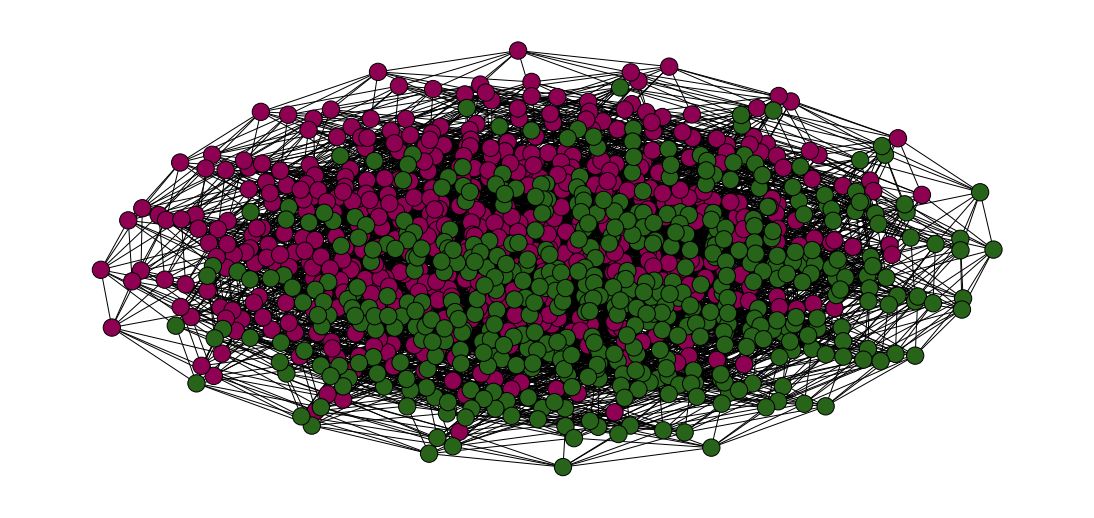

In [3]:
# Let's add the features and the labels of the citeseer dataset
datas = []
import torch
import networkx as nx
from torch_geometric.utils import to_dense_adj
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import homophily
import numpy as np
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Let's add the features and the labels of the citeseer dataset
from torch_geometric.datasets import Planetoid, WikipediaNetwork
from torch_geometric.utils import homophily
dataset = Planetoid(root='./data', name='citeseer')
#dataset = WikipediaNetwork(root='./data', name='squirrel')
data_citeseer = dataset[0]
print(data_citeseer)
print("Number of classes: ", dataset.num_classes)
# Let's choose 35 nodes from each class of citeseer
labels_of_class_0 = data_citeseer.y == 0
#features_of_class_0 = data_citeseer.x[labels_of_class_0]
data.x = torch.ones(n,1)
data.y = torch.cat((torch.zeros(int(n/2)),torch.ones(int(n/2))),dim=0).reshape(-1,1)
# Let's permutate the nodes
print("Number of nodes of class 0: ",len(data.y[data.y==0]))
print("Number of nodes of class 1: ",len(data.y[data.y==1]))
# Let's create the train and test mask
print(data)
# PLot the graph
plt.figure(figsize=(15,7))
nx.draw(G,
        pos=pos,
        node_color= data.y,
        edge_color='black',
        width=1,
        style='solid',
        linewidths=1,
        cmap=plt.cm.PiYG,
        #node_size=100,
        with_labels=False,
        alpha=1,
        edgecolors='black'
        
        )
print(data)

In [4]:
# Now we are going to split the edges of the graph in train, validation and test
from torch_geometric.utils import train_test_split_edges
from torch_geometric.seed import seed_everything as th_seed
import torch_geometric.transforms as T
seed = 1234
th_seed(seed)
# Now we are going to apply a transformation to the dataset
transform = T.Compose([
    #T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0, num_test=0.1,),
])
train_data, val_data, test_data = transform(data)
#new_data = new_data[1]
#print(new_data)

In [5]:
print("Train data: ",train_data)
print("Validation data: ",val_data)
print("Test data: ",test_data)

Train data:  Data(edge_index=[2, 9216], num_nodes=1024, x=[1024, 1], y=[1024, 1], edge_label=[18432], edge_label_index=[2, 18432])
Validation data:  Data(edge_index=[2, 9216], num_nodes=1024, x=[1024, 1], y=[1024, 1], edge_label=[0], edge_label_index=[2, 0])
Test data:  Data(edge_index=[2, 9216], num_nodes=1024, x=[1024, 1], y=[1024, 1], edge_label=[2048], edge_label_index=[2, 2048])


In [6]:
adj = to_dense_adj(data.edge_index)[0] # Convert the sparse adjacency matrix to a dense adjacency matrix
#parse train_data.y to a torch tensor long
train_data.y = train_data.y.long()
val_data.y = val_data.y.long()
test_data.y = test_data.y.long()
# Parse train_data.x to a torch tensor float
train_data.x = train_data.x.float()
val_data.x = val_data.x.float()
test_data.x = test_data.x.float()
# Parse train_data.edge_index to a torch tensor long
train_data.edge_index = train_data.edge_index.long()
val_data.edge_index = val_data.edge_index.long()
test_data.edge_index = test_data.edge_index.long()
# Parse train_data.edge_index_label to a torch tensor long
#train_data.edge_index_label = train_data.pos_edge_label.long()
#val_data.edge_index_label = val_data.pos_edge_label.long()
#test_data.edge_index_label = test_data.pos_edge_label.long()

In [7]:
import torch
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from torch_geometric.utils import negative_sampling
def train(model,train_data,optimizer,criterion,adj):
    #train_data.edge_label_index = train_data.pos_edge_label_index
    #train_data.edge_label = train_data.pos_edge_label
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x,train_data.edge_index,adj)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label) + model.losses
    loss.backward()
    optimizer.step()
    return loss, roc_auc_score(edge_label.cpu().numpy(), out.detach().cpu().numpy()),average_precision_score(edge_label.cpu().numpy(), out.detach().cpu().numpy())


@torch.no_grad()
def test(model,data,adj):
    model.eval()
    z = model.encode(data.x, data.edge_index,adj)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy()),average_precision_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


In [8]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv, DenseGCNConv,APPNP
from torch_geometric.utils import to_dense_adj
import torch.nn.functional as F
from pump import *

class LinkWIRE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels,num_centers,adj_dim,out_channels,drop_out = 0.35):
            super(LinkWIRE, self).__init__()
            torch.manual_seed(1234)
            self.MLP = Linear(adj_dim, hidden_channels)
            self.MLP2 = Linear(hidden_channels, num_centers)
            #GNN
            self.pre_conv = GCNConv(in_channels, hidden_channels)
            self.convs = DenseGCNConv(in_channels,hidden_channels)
            self.convs2 = DenseGCNConv(in_channels, hidden_channels)
            self.convs3 = DenseGCNConv(hidden_channels, hidden_channels)
            self.convs4 = DenseGCNConv(hidden_channels, hidden_channels)
            #Aux
            self.drop_out = drop_out
            # Loss
            self.losses = 0
    def encode(self, x, edge_index,adj):
        empty_adj = torch.zeros_like(adj)
        empty_adj[edge_index[0],edge_index[1]] = 1
        s = self.MLP(empty_adj)
        s = self.MLP2(s)
        _, pump_loss, ortho_loss,distance_matrix= pump(empty_adj, s)
        distance_matrix = distance_matrix.squeeze(0)
        self.losses = pump_loss + ortho_loss
        return s
    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)
    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [12]:
#from models import *
#from utils import *
resultados = []
for seeds in range(1,11):
    th_seed(seeds)
    print("The seed is: ",seeds)
    # Now we are going to apply a transformation to the dataset
    transform = T.Compose([
        #T.NormalizeFeatures(),
        T.ToDevice(device),
        T.RandomLinkSplit(num_val=0, num_test=0.1,),
    ])
    train_data, val_data, test_data = transform(data)
    model = LinkWIRE(in_channels=1, hidden_channels=1024,num_centers = 600,adj_dim = adj.shape[0],out_channels=dataset.num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.007)
    criterion = torch.nn.BCEWithLogitsLoss()
    #criterion = torch.nn.MSELoss()
    best_val_auc = 0
    best_test_auc = 0
    final_test_auc = 0
    final_val_auc = 0
    final_test_ap = 0
    final_val_ap = 0
    best_model = None
    for epoch in range(1, 200+1):
        loss,auc_train,ap_train = train(model,train_data,optimizer,criterion,adj)
        #val_auc,val_ap = test(model,val_data,adj)
        test_auc,test_ap = test(model,test_data,adj)
        if test_auc >= best_test_auc:
            best_test_auc = test_auc        
            final_test_auc = test_auc
            final_test_ap = test_ap
        #if val_auc >= best_val_auc:
        #    best_val_auc = val_auc
        #    final_val_auc = val_auc
        #    final_val_ap = val_ap 
            # Save the model weights
        #    torch.save(model.state_dict(), 'model_weights.pt')
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, AUC: {auc_train:.4f}, AP: {ap_train:.4f}, Val AUC: {0:.4f}, Val AP: {0:.4f}, Test AUC: {test_auc:.4f}, Test AP: {test_ap:.4f}')
    print("The results for the split: ",seed," is for validation: AUC: ",final_val_auc," AP: ",final_val_ap," and for test: AUC: ",final_test_auc," AP: ",final_test_ap)
    resultados.append(final_test_auc)
print("The mean of the results is: ",np.mean(resultados)," and the std is: ",np.std(resultados))

The seed is:  1
Epoch: 001, Loss: 18.9156, AUC: 0.4760, AP: 0.2306, Val AUC: 0.0000, Val AP: 0.0000, Test AUC: 0.6946, Test AP: 0.6615
Epoch: 002, Loss: 18.9782, AUC: 0.8796, AP: 0.7247, Val AUC: 0.0000, Val AP: 0.0000, Test AUC: 0.8515, Test AP: 0.8346
Epoch: 003, Loss: 19.0066, AUC: 0.9644, AP: 0.9123, Val AUC: 0.0000, Val AP: 0.0000, Test AUC: 0.9491, Test AP: 0.9298
Epoch: 004, Loss: 18.7523, AUC: 0.9901, AP: 0.9683, Val AUC: 0.0000, Val AP: 0.0000, Test AUC: 0.9722, Test AP: 0.9575
Epoch: 005, Loss: 18.4757, AUC: 0.9948, AP: 0.9825, Val AUC: 0.0000, Val AP: 0.0000, Test AUC: 0.9781, Test AP: 0.9662
Epoch: 006, Loss: 18.4174, AUC: 0.9961, AP: 0.9876, Val AUC: 0.0000, Val AP: 0.0000, Test AUC: 0.9799, Test AP: 0.9682
Epoch: 007, Loss: 18.4426, AUC: 0.9971, AP: 0.9908, Val AUC: 0.0000, Val AP: 0.0000, Test AUC: 0.9810, Test AP: 0.9694
Epoch: 008, Loss: 18.4777, AUC: 0.9974, AP: 0.9921, Val AUC: 0.0000, Val AP: 0.0000, Test AUC: 0.9823, Test AP: 0.9717
Epoch: 009, Loss: 18.4740, AUC: 